**TME2 FAURE Guillaume et LUCAS Garance** et Mathis K

In [1]:
#!pip install -U dice-ml
#!pip install torch

**Import**

In [1]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dice_ml 
from dice_ml.utils import helpers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/home/pidoux/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


**half moons**

In [25]:
def creation_dataset(n_samples,shuffle, noise, proportion):
    X, y = make_moons(n_samples=n_samples, shuffle = shuffle, noise=noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=proportion)
    assemblage = np.hstack((X_train, y_train.reshape(-1,1)))
    train_pd = pd.DataFrame(assemblage, columns= ["x0", "x1","outcome"])
    test_pd = pd.DataFrame(X_test, columns= ["x0", "x1"])
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)
    return X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t

In [26]:
X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t = creation_dataset(1000, True, 0.05,0.3)

**Régression logistique format torch**

In [27]:
# Créer un modèle de régression logistique simple
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = 2
model = LogisticRegressionModel(input_dim)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch+1}/{num_epochs}], Perte: {loss.item()}')

# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Époque [100/1000], Perte: 0.3447000980377197
Époque [200/1000], Perte: 0.3038982152938843
Époque [300/1000], Perte: 0.2829658091068268
Époque [400/1000], Perte: 0.26964661478996277
Époque [500/1000], Perte: 0.260311484336853
Époque [600/1000], Perte: 0.2534204125404358
Époque [700/1000], Perte: 0.24816539883613586
Époque [800/1000], Perte: 0.24406395852565765
Époque [900/1000], Perte: 0.24080435931682587
Époque [1000/1000], Perte: 0.23817487061023712


**DICE sur régression logistique**

In [40]:
def dice_train(dataframe, continuous_features,outcome_name, model, backend):
    d = dice_ml.Data(dataframe=dataframe, continuous_features=continuous_features, outcome_name=outcome_name)
    m = dice_ml.Model(model=model, backend=backend)
    exp = dice_ml.Dice(d, m)
    return exp

def dice_test(query_instance, exp, total_CFs, desired_class):
    counterfact = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class=desired_class)
    return counterfact

def visualize_table(counterfact, only_change):
    return counterfact.visualize_as_dataframe(show_only_changes= only_change)

def visualize_plot(counterfact,X_train_t, X_test_t, y_train_t, model):
    plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
    x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
    y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Frontière de décision')
    plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
    points = counterfact.cf_examples_list[0].final_cfs_df.to_numpy()
    plt.plot(points[:, 0], points[:, 1], 'k.')
    plt.show()
    return 

100%|██████████| 1/1 [00:11<00:00, 11.02s/it]

Query instance (original outcome : 1)


,x0,x1,outcome
0,1.927003,0.264754,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.7347707055,0.6219776289,0.0
1,1.4520574551,0.26475447973273136,0.0
2,0.3117148864,0.5577313024,0.0
3,1.927002605661918,0.8754858065,0.0
4,-1.0575409087,1.0983418513,0.0
5,-0.6533611591,0.26475447973273136,0.0
6,0.6806972145,0.5217023521,0.0
7,0.2180617805,0.8063127644,0.0
8,0.110521643,1.0982824436,0.0
9,-0.4624889602,0.29904322559991725,0.0


None


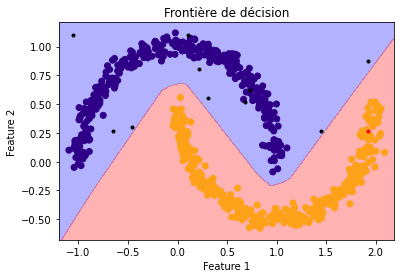

In [42]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
dice_te = dice_test(test_pd[0:1], dice_tr,10, desired_class= "opposite")
print(visualize_table(dice_te, True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

Avec un reseau de neurones sur Pytorch 

In [32]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_t.shape[1]
model = SimpleNN(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Évaluer le modèle sur des données de test
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Epoch [100/5000], Loss: 0.3672
Epoch [200/5000], Loss: 0.2461
Epoch [300/5000], Loss: 0.1951
Epoch [400/5000], Loss: 0.1600
Epoch [500/5000], Loss: 0.1309
Epoch [600/5000], Loss: 0.1056
Epoch [700/5000], Loss: 0.0843
Epoch [800/5000], Loss: 0.0670
Epoch [900/5000], Loss: 0.0534
Epoch [1000/5000], Loss: 0.0430
Epoch [1100/5000], Loss: 0.0350
Epoch [1200/5000], Loss: 0.0288
Epoch [1300/5000], Loss: 0.0241
Epoch [1400/5000], Loss: 0.0203
Epoch [1500/5000], Loss: 0.0173
Epoch [1600/5000], Loss: 0.0149
Epoch [1700/5000], Loss: 0.0129
Epoch [1800/5000], Loss: 0.0112
Epoch [1900/5000], Loss: 0.0099
Epoch [2000/5000], Loss: 0.0087
Epoch [2100/5000], Loss: 0.0077
Epoch [2200/5000], Loss: 0.0069
Epoch [2300/5000], Loss: 0.0062
Epoch [2400/5000], Loss: 0.0056
Epoch [2500/5000], Loss: 0.0050
Epoch [2600/5000], Loss: 0.0045
Epoch [2700/5000], Loss: 0.0041
Epoch [2800/5000], Loss: 0.0038
Epoch [2900/5000], Loss: 0.0034
Epoch [3000/5000], Loss: 0.0031
Epoch [3100/5000], Loss: 0.0029
Epoch [3200/5000]

**DICE sur NN**

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:24<00:00, 10.20s/it]

Query instance (original outcome : 1)


,x0,x1,outcome
0,1.927003,0.264754,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,1.5718189779,0.36676303279991723,0.0
1,1.1269741184,0.26475447973273136,0.0
2,0.5286351555,0.26475447973273136,0.0
3,1.927002605661918,0.8185149483,0.0
4,1.2356207738,0.26475447973273136,0.0
5,0.7342003247,0.9948697084,0.0
6,0.2169150747,1.0535977961,0.0
7,-0.7064018391,0.26475447973273136,0.0
8,1.2245648884,0.26475447973273136,0.0
9,1.1859038883,0.26475447973273136,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,1.760435,-0.193273,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,1.7159019212000828,0.6687206015,0.0
1,0.6146137603,0.8936239296,0.0
2,-0.9321953718,0.0340866823,0.0
3,1.7604344530296845,0.8337005751,0.0
4,-0.6327992825,0.7952280559,0.0
5,1.7604344530296845,1.1160466587,0.0
6,-0.8307430957,0.0250011167,0.0
7,0.9965341167,-0.09427421289994396,0.0
8,1.7604344530296845,0.5956238294,0.0
9,1.7604344530296845,0.7319259424,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.0107,0.3189,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.010699663780706734,0.9570922908,0.0
1,-0.3725863443,0.7522026511,0.0
2,1.2074028178,0.31889961944350337,0.0
3,1.423012919,0.31889961944350337,0.0
4,0.3288487947,0.9570922908,0.0
5,1.1089146553,0.31889961944350337,0.0
6,0.6314862987,0.31889961944350337,0.0
7,0.8352282979,0.24094722960008275,0.0
8,1.4067785188,0.31889961944350337,0.0
9,1.98542792,0.9809886571,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,1.04028,0.088594,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.5199272233,-0.2617891307,1.0
1,0.9356721555000828,-0.3220429571,1.0
2,1.0402797130753574,-0.391962361,1.0
3,-0.5697427845,0.08859423543466574,1.0
4,0.6208504713,0.08859423543466574,1.0
5,-0.3374434702,0.07202939379994397,1.0
6,1.8391232081,0.08859423543466574,1.0
7,1.8905110068,0.08859423543466574,1.0
8,1.0402797130753574,-0.3505055627,1.0
9,1.0402797130753574,-0.5403358916,1.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.940979,0.167312,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.0073501782,0.3410540756,1.0
1,-0.1954576155,0.16731198260532737,1.0
2,0.0731422701,0.16731198260532737,1.0
3,0.9409791299023957,-0.3803100313,1.0
4,0.4067763622,0.20108446649991726,1.0
5,1.9798942895,0.16731198260532737,1.0
6,0.3247972685,-0.158855301,1.0
7,1.8179055914,-0.4285361562,1.0
8,0.9409791299023957,-0.4362415015,1.0
9,0.0114303719,-0.1048144952,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.916635,-0.434718,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.9166347957798849,0.0454113112,0.0
1,0.9166347957798849,0.1219670864,0.0
2,0.9166347957798849,0.8360380227,0.0
3,0.9166347957798849,0.8400793443,0.0
4,0.9166347957798849,0.6364456376,0.0
5,0.9166347957798849,0.9746241053,0.0
6,-0.4992785715,0.3794538885,0.0
7,1.482331891,0.3061279527,0.0
8,0.9166347957798849,0.8372467052,0.0
9,0.9166347957798849,0.4914564433,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.992516,0.266569,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,1.8842131849,-0.2684193196,1.0
1,-0.7776137305,-0.5521663151,1.0
2,1.9591975717,0.26656869664991556,1.0
3,0.9925162598837842,-0.4248464223,1.0
4,0.9925162598837842,-0.5109269307,1.0
5,-0.6007623855,-0.0763813063,1.0
6,0.9925162598837842,-0.3126254539,1.0
7,-0.1082722366,0.6385548445,1.0
8,0.128214424,0.19441275580008274,1.0
9,0.2712362074,0.26656869664991556,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.580804,-0.396233,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.5808042821107355,0.777373608,0.0
1,0.5808042821107355,0.9529375726,0.0
2,0.5808042821107355,0.8381386475,0.0
3,0.2777523909,0.9329552807,0.0
4,-1.0198026821,-0.0803287149,0.0
5,-0.270293131,0.5376770306,0.0
6,1.3792434784,0.4522559757,0.0
7,0.5808042821107355,1.0623309669,0.0
8,0.7715415172,0.3990309507,0.0
9,0.2649795841,0.6345272414,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.097012,0.024864,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.12390198740005604,0.7266592724,0.0
1,-0.7972225106,0.3502602219,0.0
2,-0.9299875748,0.024864429810228638,0.0
3,-0.838961461,0.024864429810228638,0.0
4,0.860482346,0.9973656486,0.0
5,1.2830371989,0.4631713812,0.0
6,0.09701187212632982,0.9288403819,0.0
7,0.4856430177,0.2486120871,0.0
8,1.3838358637,0.2217749598,0.0
9,0.6593989033,0.5945913023,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.076354,0.113208,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,-0.6995965253,0.11320829994850945,0.0
1,0.07635413518219837,0.9056855316,0.0
2,1.1279807777,0.11320829994850945,0.0
3,0.07635413518219837,1.0897308897,0.0
4,0.5263016106,0.2930522152,0.0
5,0.6456511664,0.11320829994850945,0.0
6,-0.9455660322,0.11320829994850945,0.0
7,0.9866492863,0.11320829994850945,0.0
8,0.7286037644,1.0766706145,0.0
9,1.0590614547,0.11320829994850945,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.985644,-0.466988,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,-1.0545871753,-0.46698836724638637,0.0
1,1.4100316747,0.7159749255,0.0
2,0.9856439682040065,-0.1716124682,0.0
3,1.169278521,0.132286391,0.0
4,0.9856439682040065,0.0167395093,0.0
5,0.9856439682040065,0.0960877235,0.0
6,0.4861339751,1.0174967099,0.0
7,-0.9001913561,0.4422292652,0.0
8,0.9856439682040065,0.9438006278,0.0
9,1.185085088,0.6836216853,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.432053,-0.350013,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,1.8346089307,0.8392040793,0.0
1,0.4796898078999173,0.8565615949,0.0
2,0.432053242529035,0.4105426418,0.0
3,-1.058175444,-0.35001311017758224,0.0
4,0.432053242529035,0.3575030831,0.0
5,-1.0815838486,-0.35001311017758224,0.0
6,0.2972694868,0.7488397886,0.0
7,0.5561393388,0.7496113276,0.0
8,0.432053242529035,0.9154193354,0.0
9,-0.5053233273,1.0819442664,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.766716,-0.548968,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.7667157618654071,1.0844887251,0.0
1,0.7667157618654071,0.9260208823,0.0
2,1.0013146181,0.3806297127,0.0
3,0.7667157618654071,0.1614580449,0.0
4,-0.5209458216,0.5070647562,0.0
5,0.7667157618654071,0.0913735897,0.0
6,0.7667157618654071,0.6488580439,0.0
7,0.7667157618654071,0.5454244315,0.0
8,0.7667157618654071,0.075062538,0.0
9,0.7667157618654071,0.0055480969,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.098685,0.929735,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.09868533671008944,0.3181779902,1.0
1,0.3861669338,0.1576782869,1.0
2,0.2571830889,-0.0927163293,1.0
3,0.9928390931,-0.2738575067,1.0
4,0.09868533671008944,0.5043586279,1.0
5,1.6678557637,-0.3731663312,1.0
6,0.09868533671008944,-0.1039721182,1.0
7,2.0811557856,-0.2237783797,1.0
8,0.09868533671008944,0.1900241555,1.0
9,0.09868533671008944,-0.060160602,1.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.107876,1.039815,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.10787638078136767,-0.0061674313,1.0
1,0.10787638078136767,-0.2061528045,1.0
2,0.7391251275,-0.1226788807,1.0
3,0.8572553111,-0.1561360506,1.0
4,0.5548687115,-0.2671071342,1.0
5,1.3201159603,-0.3636812105,1.0
6,0.10787638078136767,-0.2571177538,1.0
7,0.21949729849991725,0.3072567715,1.0
8,0.16078644589991725,-0.2954675433,1.0
9,-0.2879656071,-0.4276980785,1.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.574131,0.821719,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,2.0419867415,-0.2422378872,1.0
1,0.5741312251121842,-0.2527661421,1.0
2,0.5741312251121842,-0.0120250422,1.0
3,2.0565204774,0.8217188033015849,1.0
4,0.5741312251121842,0.0744043266,1.0
5,0.0576063135,0.0328039688,1.0
6,1.6557968117,0.3577040105,1.0
7,1.2781003331,-0.1470263918,1.0
8,0.5741312251121842,-0.2325344608,1.0
9,-0.2108235757,-0.5402066065,1.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,-1.065997,0.078126,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.0251880733,0.07812600901032724,1.0
1,-0.3669062535,0.08214857280005604,1.0
2,-0.5856583499,-0.1709740466,1.0
3,0.2093217323,-0.4682221031,1.0
4,2.0447403019,0.07812600901032724,1.0
5,1.8539258242,0.07812600901032724,1.0
6,1.2983927814,-0.02333390299998665,1.0
7,-0.1938745536,0.07812600901032724,1.0
8,-1.0659973487270746,-0.5645866091,1.0
9,-0.1713722697,0.07812600901032724,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.08651,0.317158,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.8682611436,0.31715819070952467,0.0
1,1.503087779,0.31715819070952467,0.0
2,1.4089369685,0.30607864250008276,0.0
3,0.08650978785815605,1.0866459872,0.0
4,-1.0390405289,0.6688438366,0.0
5,-0.124479381,0.9725962318,0.0
6,1.1229561609,0.31715819070952467,0.0
7,0.08650978785815605,0.7073861956,0.0
8,0.9635093994,0.31715819070952467,0.0
9,-0.8724321354,0.31715819070952467,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,-0.184405,0.967587,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.0627235683,-0.3516212921,1.0
1,0.6586344491,-0.3353392769,1.0
2,-0.11746144399994396,0.0590574047,1.0
3,-0.6164996336,-0.0879297634,1.0
4,-0.0606775913,-0.0281898085,1.0
5,-0.1844047280355423,0.4213346457,1.0
6,-0.1844047280355423,-0.1624953171,1.0
7,-0.1844047280355423,-0.0457804044,1.0
8,-0.15918737660008275,0.4711773355,1.0
9,1.4950769807,-0.052304441,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,2.008467,0.279602,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,1.0894150627,0.2696931375000827,0.0
1,1.3446080892,1.0384797864,0.0
2,0.8153781657,0.27960172995173865,0.0
3,0.5697843704,0.27960172995173865,0.0
4,0.8176787848,0.27960172995173865,0.0
5,-1.0257371378,0.27960172995173865,0.0
6,-0.848974895,0.27960172995173865,0.0
7,-0.4217932896,0.6537865491,0.0
8,-0.9795182421,0.1069783038,0.0
9,2.0084673151792933,1.0727175648,0.0


None


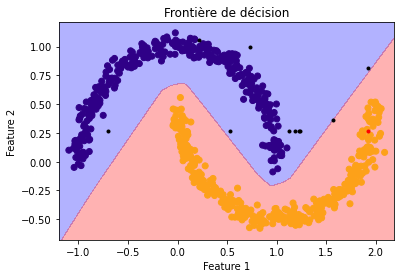

In [96]:

dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
query = test_pd[0:20]
dice_te = dice_test(query, dice_tr,10, desired_class= "opposite")
print(visualize_table(dice_te,True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

**Validity**

In [109]:
def prediction_class(model, X_test_t):
    with torch.no_grad():
        predicted = model(X_test_t)
        predicted_class = (predicted >= 0.5).float()
    return predicted_class

def validity(dice_te, prediction, total_cfs):
        w=0
        for i in range(len(prediction)):
                q = np.ones(total_cfs) * np.array(prediction.reshape(-1)[i])
                sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[:,-1].reshape(-1)
                w += np.sum(np.where(q!=sol,1,0))

        return w/(len(prediction) * total_cfs)

In [110]:
prediction = prediction_class(model,X_test_t[0:2])
validity(dice_te, prediction, 10)

1.0

**continuous_Proximity**

In [171]:
def continuous_proximity(dice_te, query):
    n = query.shape[1]
    norma =[]
    for i in range(len(prediction)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(len(sol)):
            norm += np.linalg.norm(sol[j]-query[i])
        norma.append(-norm/len(sol))
    return norma


In [173]:
continuous_proximity(dice_te, X_test[0:2])

[-1.1171797987749241, -1.515504803507899]

Pour la proximité categorielle qui n'est pas nécessaire ici, on attribue 1 si la dimension est de la meme classe sinon 0.

In [ ]:
def categorial_proximity(dice_te, query):
    n = query.shape[1]
    norma =[]
    for i in range(len(prediction)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(len(sol)):
            for k in range(len(sol[j])):
                d += np.sum(np.where(sol[j][k] != query[i][k], 1, 0))
            d = d/len(sol[j])
        norma.append(1 - (d / len(sol)))
    return norma

Local feature importance scores

In [139]:
imp = dice_tr.local_feature_importance(query, total_CFs=100)
print(imp.local_importance)

  0%|          | 0/20 [00:10<?, ?it/s]


KeyboardInterrupt: 

Global feature importance scores

In [39]:
query_instances = test_pd[0:20]
imp = dice_tr.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 20/20 [01:48<00:00,  5.44s/it]

{'x1': 0.765, 'x0': 0.64}


**DICE sur autre donnée**

In [ ]:
dataset =helpers.load_adult_income_dataset()
target = dataset['income']
train_dataset, test_dataset, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0,stratify=target)

# initialise DiCE
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age','hours_per_week'], outcome_name='income') 

m= dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend='TF2',func ="ohe-min-max")
exp = dice_ml.Dice(d,m)
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()